# Installations

In [15]:
!pip install boto3 awscli -q

# Imports

In [28]:
# --- System and Utility Imports ---
import os
import json
import random
import datetime
from collections import Counter
import pickle
import shutil

# --- AWS and Cloud Utilities ---
import boto3
from botocore.exceptions import NoCredentialsError

# --- Image and Video Processing ---
from PIL import Image
import cv2

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning, Deep Learning & Model Evaluation ---
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Progress Tracking ---
from tqdm import tqdm

# --- Check AWS CLI version ---
!aws --version

aws-cli/1.41.3 Python/3.11.13 Linux/6.1.123+ botocore/1.39.3


# Global Variables

In [17]:
# Global Variables
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
S3_BUCKET_NAME = 'lung-cancer-project-data'
drive_folder = "/content/drive/MyDrive/ResNet50-training-progress"
LOCAL_DATASET_PATH = '/content/drive/MyDrive/lung-cancer-project-data/datasets/histopathology'

# Ensure Drive directory exists
drive_dir = drive_folder
os.makedirs(drive_dir, exist_ok=True)

# AWS Credentials

In [ ]:
os.environ["AWS_ACCESS_KEY_ID"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_SECRET_ACCESS_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_DEFAULT_REGION"] = "ap-south-1"

# Exploratory Data Analysis

## EDA on the Training Dataset

Classes found in 'train': ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

 Image Count per Class:
                      Class  Image Count
0           adenocarcinoma         3500
1                   benign         3500
2  squamous_cell_carcinoma         3510

 Image Shape Distribution (from 5 samples/class):
       Width  Height
count   15.0    15.0
mean   224.0   224.0
std      0.0     0.0
min    224.0   224.0
25%    224.0   224.0
50%    224.0   224.0
75%    224.0   224.0
max    224.0   224.0


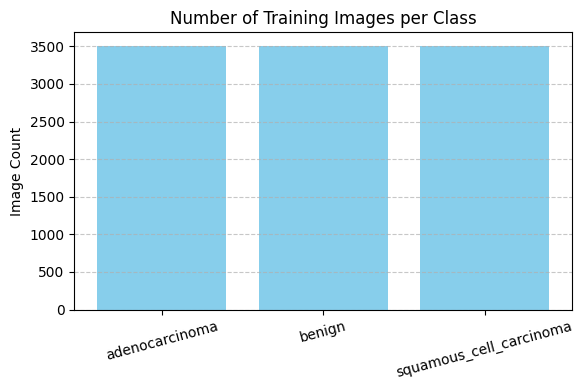

In [19]:
train_dir = os.path.join(LOCAL_DATASET_PATH, 'train')
categories = sorted(os.listdir(train_dir))

print("Classes found in 'train':", categories)

# Count images per class
class_counts = {}
image_shapes = []

for category in categories:
    class_path = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[category] = len(image_files)

    # Sample image shape extraction
    for img_file in image_files[:5]:  # Just 5 per class to avoid I/O overhead
        img = Image.open(os.path.join(class_path, img_file))
        image_shapes.append(img.size)
        img.close()

# Printing class counts
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
print("\n Image Count per Class:\n", df_counts)

# Image resolution stats
res_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print("\n Image Shape Distribution (from 5 samples/class):")
print(res_df.describe())

# Number of Training Images per Class: Bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Number of Training Images per Class')
plt.ylabel('Image Count')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyze sample image for mode, shape, channels, and color distribution


 Sample image path: /content/drive/MyDrive/lung-cancer-project-data/datasets/histopathology/train/adenocarcinoma/3769.jpg
 Image shape (H, W, Channels): (224, 224, 3)
 Image mode (PIL): RGB

 Sample pixel array (top-left corner):
[[[166 159 236]
  [181 178 249]
  [193 193 255]]

 [[170 163 241]
  [181 177 251]
  [190 190 254]]

 [[172 163 244]
  [183 176 253]
  [188 187 253]]]

 RGB Channel Mean Values: [181.63833307 171.17793367 247.40507414]
 RGB Channel Std Dev Values: [29.39308694 42.06497215 11.8290918 ]


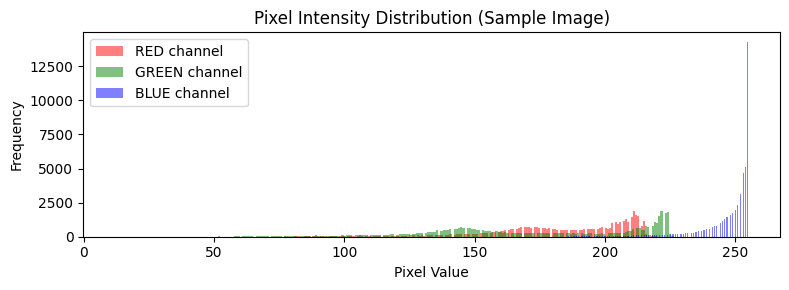

In [20]:
sample_path = os.path.join(train_dir, categories[0], os.listdir(os.path.join(train_dir, categories[0]))[0])
img = Image.open(sample_path)
img_np = np.array(img)

print(f"\n Sample image path: {sample_path}")
print(f" Image shape (H, W, Channels): {img_np.shape}")
print(f" Image mode (PIL): {img.mode}")

# Show pixel array (only top-left corner for readability)
print("\n Sample pixel array (top-left corner):")
print(img_np[:3, :3])  # print top-left 3x3 region

# Per channel statistics if image is RGB
if img.mode == "RGB" and len(img_np.shape) == 3:
    channel_means = np.mean(img_np, axis=(0, 1))
    channel_stds = np.std(img_np, axis=(0, 1))
    print("\n RGB Channel Mean Values:", channel_means)
    print(" RGB Channel Std Dev Values:", channel_stds)

    # Plot channel distributions
    plt.figure(figsize=(8, 3))
    colors = ['red', 'green', 'blue']
    for i in range(3):
        plt.hist(img_np[:, :, i].ravel(), bins=256, color=colors[i], alpha=0.5, label=f'{colors[i].upper()} channel')
    plt.title("Pixel Intensity Distribution (Sample Image)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Image is not in RGB format or has unexpected shape. Skipping color analysis.")

img.close()

## Sample images

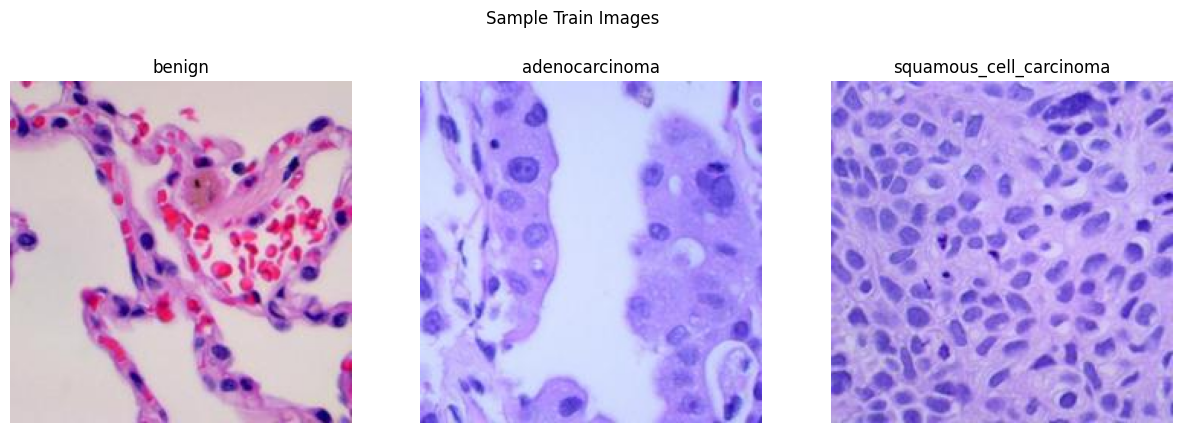

In [21]:
def plot_sample_images(directory, title):
    categories = os.listdir(directory)
    plt.figure(figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        sample_image = os.listdir(category_path)[0]
        img = tf.keras.utils.load_img(os.path.join(category_path, sample_image))
        plt.subplot(1, len(categories), i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images(os.path.join(LOCAL_DATASET_PATH, 'train'), 'Sample Train Images')

# Data Preprocessing + Augmentation

In [24]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_data = val_test_datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save class indices to a JSON file
class_indices = train_data.class_indices
class_indices_path = os.path.join(drive_dir, "resnet50_class_indices.json")

# Save locally (e.g., Google Drive)
with open(class_indices_path, "w") as f:
    json.dump(class_indices, f)

print("✅ Saved class indices locally:", class_indices_path)

# Upload to S3
s3 = boto3.client('s3')
s3_key = "model-artifacts/histopathology_test_models/class_indices/resnet50_class_indices.json"

try:
    s3.upload_file(class_indices_path, S3_BUCKET_NAME, s3_key)
    print(f"✅ Uploaded class indices to S3: s3://{S3_BUCKET_NAME}/{s3_key}")
except NoCredentialsError:
    print("⚠️ AWS credentials not found. Could not upload class indices to S3.")

Found 10510 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
✅ Saved class indices locally: /content/drive/MyDrive/ResNet50-training-progress/resnet50_class_indices.json
✅ Uploaded class indices to S3: s3://lung-cancer-project-data/model-artifacts/histopathology_test_models/class_indices/resnet50_class_indices.json


# Build Model (Resnet50)

In [25]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(patience=2, factor=0.2, verbose=1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train Model

## Session 1: (Epochs 0–4) – Feature Extraction

In [26]:
if not os.path.exists(os.path.join(drive_dir, "history_1.pkl")):
    print("Training Session 1 (Epochs 0–4)...")

    history_1 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=5,
        callbacks=[early_stop, lr_schedule]
    )

    model.save(os.path.join(drive_dir, "resnet50_epoch4.h5"))
    with open(os.path.join(drive_dir, "history_1.pkl"), "wb") as f:
        pickle.dump(history_1.history, f)
else:
    print("Session 1 already completed. Skipping...")

Training Session 1 (Epochs 0–4)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2935s 9s/step - accuracy: 0.5272 - loss: 1.2874 - val_accuracy: 0.8711 - val_loss: 0.3114 - learning_rate: 1.0000e-04
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2316s 7s/step - accuracy: 0.8115 - loss: 0.4441 - val_accuracy: 0.9142 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2300s 7s/step - accuracy: 0.8783 - loss: 0.3032 - val_accuracy: 0.9240 - val_loss: 0.1786 - learning_rate: 1.0000e-04
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2309s 7s/step - accuracy: 0.8943 - loss: 0.2561 - val_accuracy: 0.9280 - val_loss: 0.1710 - learning_rate: 1.0000e-04
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2356s 7s/step - accuracy: 0.9099 - loss: 0.2314 - val_accuracy: 0.9351 - val_loss: 0.1534 - learning_rate: 1.0000e-04


## Session 2 (Epochs 4–8) – Fine-tune top 30 layers

In [29]:
if not os.path.exists(os.path.join(drive_dir, "history_2.pkl")):
    print("Training Session 2 (Epochs 4–8)...")

    model = load_model(os.path.join(drive_dir, "resnet50_epoch4.h5"))
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    history_2 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=8,
        initial_epoch=4,
        callbacks=[early_stop, lr_schedule]
    )

    model.save(os.path.join(drive_dir, "resnet50_epoch8.h5"))
    with open(os.path.join(drive_dir, "history_2.pkl"), "wb") as f:
        pickle.dump(history_2.history, f)
else:
    print("Session 2 already completed. Skipping...")

Training Session 2 (Epochs 4–8)...


Epoch 5/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 2316s 7s/step - accuracy: 0.9189 - loss: 0.2079 - val_accuracy: 0.9351 - val_loss: 0.1515 - learning_rate: 1.0000e-05
Epoch 6/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 2310s 7s/step - accuracy: 0.9231 - loss: 0.1943 - val_accuracy: 0.9356 - val_loss: 0.1538 - learning_rate: 1.0000e-05
Epoch 7/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 2315s 7s/step - accuracy: 0.9259 - loss: 0.1900 - val_accuracy: 0.9373 - val_loss: 0.1506 - learning_rate: 1.0000e-05
Epoch 8/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 2386s 7s/step - accuracy: 0.9184 - loss: 0.1988 - val_accuracy: 0.9378 - val_loss: 0.1495 - learning_rate: 1.0000e-05


## Session 3 (Epochs 8–12) – Full fine-tuning

In [30]:
if not os.path.exists(os.path.join(drive_dir, "history_3.pkl")):
    print("Training Session 3 (Epochs 8–12)...")

    model = load_model(os.path.join(drive_dir, "resnet50_epoch8.h5"))
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    history_3 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=12,
        initial_epoch=8,
        callbacks=[early_stop, lr_schedule]
    )

    model.save(os.path.join(drive_dir, "resnet50_final.h5"))
    with open(os.path.join(drive_dir, "history_3.pkl"), "wb") as f:
        pickle.dump(history_3.history, f)
else:
    print("Session 3 already completed. Skipping...")

Training Session 3 (Epochs 8–12)...


Epoch 9/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 2331s 7s/step - accuracy: 0.9248 - loss: 0.1948 - val_accuracy: 0.9378 - val_loss: 0.1460 - learning_rate: 1.0000e-05
Epoch 10/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 2428s 7s/step - accuracy: 0.9233 - loss: 0.1960 - val_accuracy: 0.9391 - val_loss: 0.1469 - learning_rate: 1.0000e-05
Epoch 11/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 2380s 7s/step - accuracy: 0.9234 - loss: 0.1968 - val_accuracy: 0.9396 - val_loss: 0.1445 - learning_rate: 1.0000e-05
Epoch 12/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 2336s 7s/step - accuracy: 0.9250 - loss: 0.1900 - val_accuracy: 0.9391 - val_loss: 0.1438 - learning_rate: 1.0000e-05


# Save Model and Logs

In [31]:
final_model_path = os.path.join(drive_dir, "resnet50_final.h5")
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_filename = f"ResNet50_histopathology_model_{timestamp}.h5"
s3_model_path = f"model-artifacts/histopathology_test_models/{model_filename}"

s3_client = boto3.client('s3')
try:
    s3_client.upload_file(final_model_path, S3_BUCKET_NAME, s3_model_path)
    print("✅ Final model uploaded to S3.")
except NoCredentialsError:
    print("⚠️ AWS credentials not found.")

✅ Final model uploaded to S3.


# Evaluate Model

In [32]:
# Get predictions and true labels
pred_probs = model.predict(test_data)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes

# Classification report
target_names = list(test_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:\n")
print(report)

71/71 ━━━━━━━━━━━━━━━━━━━━ 545s 8s/step
Classification Report:

                         precision    recall  f1-score   support

         adenocarcinoma       0.94      0.89      0.92       750
                 benign       1.00      1.00      1.00       750
squamous_cell_carcinoma       0.90      0.94      0.92       750

               accuracy                           0.95      2250
              macro avg       0.95      0.95      0.95      2250
           weighted avg       0.95      0.95      0.95      2250



## Confusion Matrix

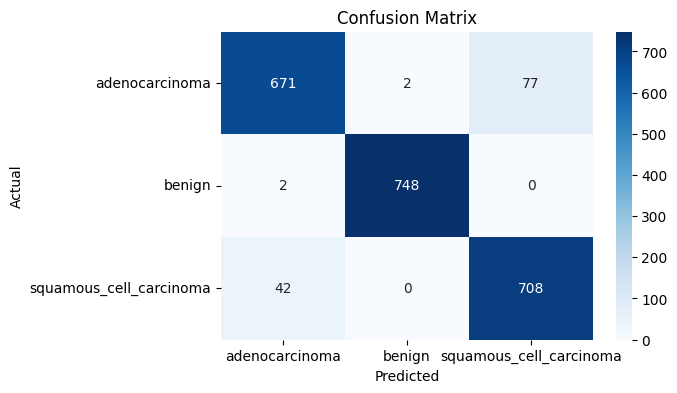

In [33]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys(), cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## ROC AUC per class

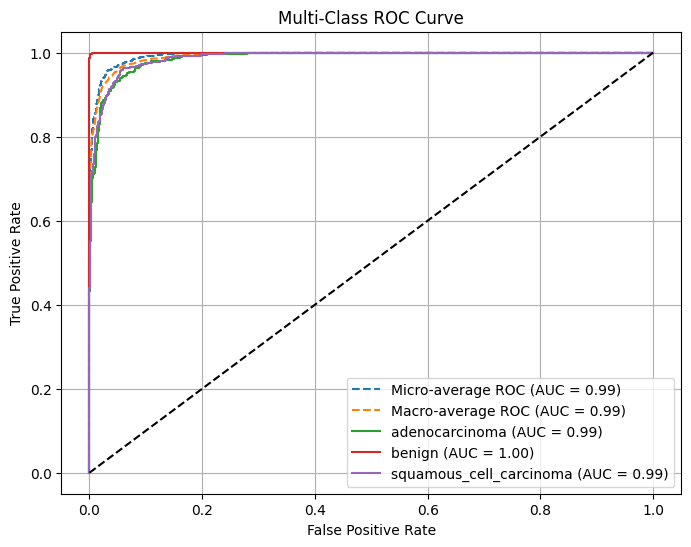


Micro-Average ROC AUC: 0.9941
Macro-Average ROC AUC: 0.9923


In [34]:
# Evaluation: ROC AUC (Micro, Macro, Per Class)
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_onehot.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{target_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"\nMicro-Average ROC AUC: {roc_auc['micro']:.4f}")
print(f"Macro-Average ROC AUC: {roc_auc['macro']:.4f}")


## Overall ROC Curve (Micro-Average)

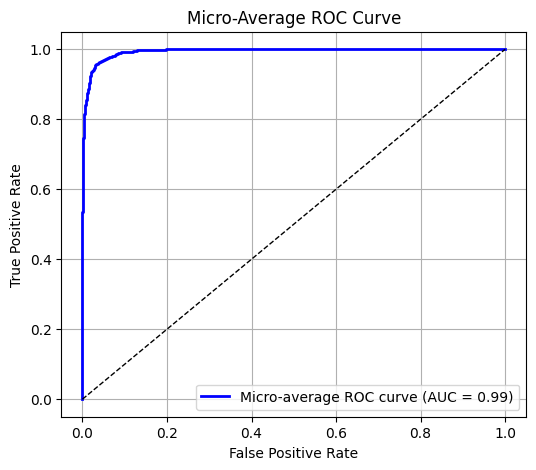

Micro-Average ROC AUC: 0.9941


In [35]:
# Compute micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_onehot.ravel(), pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot Micro-average ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUC value
print(f"Micro-Average ROC AUC: {roc_auc_micro:.4f}")


# **Histopathology Image Classification using ResNet50**

---

### **Project Overview**

This notebook demonstrates the use of a deep learning model based on **ResNet50** to classify lung cancer histopathology images into the following categories:

* **Adenocarcinoma**
* **Benign (non-cancerous)**
* **Squamous Cell Carcinoma**

The training followed a progressive strategy in 3 sessions using transfer learning, with gradual unfreezing and fine-tuning of deeper layers to improve generalization.

---

### **Exploratory Data Analysis (EDA)**

**Dataset structure**:

* The dataset is organized into train, validation, and test sets, each with three subfolders for the respective classes.

**Classes Found**:

| Class                   | Image Count |
| ----------------------- | ----------- |
| Adenocarcinoma          | 3500        |
| Benign                  | 3500        |
| Squamous Cell Carcinoma | 3510        |

**Image Stats (Sample)**:

* Shape: `(224, 224, 3)`
* Color Format: RGB
* Augmentation: Rotation, Shift, Zoom, Flip

---

### **Model Configuration**

| Setting               | Value                                |
| --------------------- | ------------------------------------ |
| Architecture          | ResNet50 (ImageNet Pretrained)       |
| Custom Head           | GAP → Dropout(0.3) → Dense (softmax) |
| Optimizer             | Adam                                 |
| Initial Learning Rate | 1e-4 (frozen) → 1e-5 (FT)            |
| Loss Function         | Categorical Crossentropy             |
| Input Size            | 224 × 224                            |
| Output Classes        | 3                                    |
| Callbacks             | EarlyStopping, ReduceLROnPlateau     |

---

### **Training Strategy**

| Phase         | Description                                         |
| ------------- | --------------------------------------------------- |
| **Session 1** | Train with base model frozen (Epochs 1–5)           |
| **Session 2** | Unfreeze top 30 layers for fine-tuning (Epochs 6–8) |
| **Session 3** | Full fine-tuning (Epochs 9–12)                      |

**Training Logs**:

| Epoch | Accuracy | Loss   | Val Accuracy | Val Loss |
| ----- | -------- | ------ | ------------ | -------- |
| 1     | 52.7%    | 1.2874 | 87.1%        | 0.3114   |
| 5     | 90.9%    | 0.2314 | 93.5%        | 0.1534   |
| 8     | 91.8%    | 0.1988 | 93.8%        | 0.1495   |
| 12    | 92.5%    | 0.1900 | 93.9%        | 0.1438   |

---

### **Evaluation Results (Test Set)**

| Metric                     | Value  |
| -------------------------- | ------ |
| **Test Accuracy**          | 95.0%  |
| **Macro-Average F1 Score** | 0.95   |
| **Micro-Average ROC AUC**  | 0.9941 |

#### **Classification Report**:

| Class                   | Precision | Recall | F1-Score |
| ----------------------- | --------- | ------ | -------- |
| Adenocarcinoma          | 0.94      | 0.89   | 0.92     |
| Benign                  | 1.00      | 1.00   | 1.00     |
| Squamous Cell Carcinoma | 0.90      | 0.94   | 0.92     |

---

### **Confusion Matrix**


* **Adenocarcinoma**: 671 correctly classified, 2 as benign, 77 as squamous
* **Benign**: 748 correctly classified
* **Squamous Cell Carcinoma**: 708 correctly classified, 42 as adenocarcinoma

---

### **Multi-Class ROC Curve**


| Class                   | AUC  |
| ----------------------- | ---- |
| Adenocarcinoma          | 0.99 |
| Benign                  | 1.00 |
| Squamous Cell Carcinoma | 0.99 |
| **Micro-Average AUC**   | 0.99 |
| **Macro-Average AUC**   | 0.99 |

---

### **Micro-Average ROC Curve**

* **AUC = 0.99**
* The curve indicates excellent model-wide discrimination.

---

### **Conclusion**

* The **ResNet50-based histopathology classifier** achieved **95% test accuracy** and **micro-AUC of 0.9941**, making it highly reliable for medical diagnostic assistance.
* Fine-tuning progressively enhanced performance over sessions.
* Benign cases were classified with perfect precision and recall.
* The evaluation visuals (ROC curves, confusion matrix) confirm clinical-grade performance.